<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/CNN_dan_MLP_(PyTorch)_SVHN_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 Model Deep Learning CNN dan MLP (PyTorch) SVHN Datasets

# Install Library

In [ ]:

%pip install numpy matplotlib scikit-learn torch tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Import Library

In [ ]:
# Import library yang diperlukan
import torch # Library utama untuk deep learning
import torch.nn as nn # Library untuk neural network
import torch.optim as optim # Library untuk optimizers
import torch.nn.functional as F # Library untuk fungsi aktivasi dan loss functions
import torchvision # Library untuk computer vision
import torchvision.transforms as transforms # Library untuk transformasi data
import numpy as np # Library untuk manipulasi array
import matplotlib.pyplot as plt # Library untuk visualisasi data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# Mengatur device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Menggunakan GPU jika tersedia, jika tidak menggunakan CPU
print(f"Menggunakan device: {device}")

Menggunakan device: cpu


# Memuat Dataset SVHN dan Augmentasi

In [ ]:
# Data transformations
# Transformasi data untuk augmentasi dan normalisasi
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])

# Memuat dataset SVHN
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Memeriksa ukuran dataset
print(f"Jumlah data pelatihan: {len(trainset)}")
print(f"Jumlah data pengujian: {len(testset)}")

# Kelas untuk SVHN dataset
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

100%|██████████| 182M/182M [00:07<00:00, 24.0MB/s]
100%|██████████| 64.3M/64.3M [00:03<00:00, 20.7MB/s]


Jumlah data pelatihan: 73257
Jumlah data pengujian: 26032


# Menyusun Model

In [12]:
# Fungsi untuk melatih model
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs=100):
    train_losses = [] # List untuk menyimpan loss
    train_accuracies = [] # List untuk menyimpan akurasi
    val_losses = [] # List untuk menyimpan loss validasi
    val_accuracies = [] # List untuk menyimpan akurasi validasi

    # Perulangan untuk setiap epoch
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train() # Mengatur model ke mode training
        # Perulangan untuk setiap batch dalam trainloader
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data # Mengambil data dan label dari batch
            # Memindahkan data dan label ke device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # Mengatur gradien ke nol sebelum backward pass

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Menghitung akurasi
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Menghitung rata-rata loss dan akurasi untuk epoch ini
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total

        # Validasi dan penyesuaian learning rate
        val_loss, val_acc = evaluate_model(model, testloader, criterion)
        scheduler.step(val_loss) # Menyesuaikan learning rate berdasarkan validasi loss

        # Menyimpan loss dan akurasi untuk epoch ini
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Fungsi untuk evaluasi model
def evaluate_model(model, dataloader, criterion):
    model.eval() # Mengatur model ke mode evaluasi
    val_loss = 0.0
    correct = 0
    total = 0

    # Perulangan untuk setiap batch dalam dataloader
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(dataloader), 100 * correct / total

# Fungsi untuk mendapatkan prediksi lengkap
def get_all_predictions(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    # Perulangan untuk setiap batch dalam dataloader
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

In [13]:
# Mendefinisikan model MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Input size: 32x32x3 = 3072
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 3, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(256, len(classes)) # Output size: 10 (jumlah kelas CIFAR-10)

    # Fungsi forward untuk melakukan forward pass
    def forward(self, x):
        x = self.flatten(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.fc5(x)

        return x

# Inisialisasi model
model_mlp = MLP().to(device)
print(model_mlp)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)


In [14]:
# Inisialisasi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Melatih model MLP dengan data augmentation
print("Melatih model MLP...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model_mlp, trainloader, criterion, optimizer, scheduler, epochs=5)

# Mengevaluasi model
print("Evaluasi akhir model...")
test_loss, test_accuracy = evaluate_model(model_mlp, testloader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Melatih model MLP...
Epoch 1, Loss: 2.2428, Accuracy: 18.75%, Val Loss: 2.1014, Val Accuracy: 28.07%
Epoch 2, Loss: 1.9975, Accuracy: 29.73%, Val Loss: 1.7348, Val Accuracy: 39.78%
Epoch 3, Loss: 1.8240, Accuracy: 36.35%, Val Loss: 1.5679, Val Accuracy: 45.70%
Epoch 4, Loss: 1.7158, Accuracy: 40.74%, Val Loss: 1.4663, Val Accuracy: 51.04%
Epoch 5, Loss: 1.6336, Accuracy: 44.23%, Val Loss: 1.3782, Val Accuracy: 53.81%
Evaluasi akhir model...
Final Test Loss: 1.3782, Test Accuracy: 53.81%


# Evaluasi Model (Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC)

In [18]:
# Metrik evaluasi yang digunakan antara lain akurasi, presisi, recall, f1-score, dan ROC AUC
# Fungsi untuk menghitung metrik evaluasi
def evaluate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')

    return accuracy, precision, recall, f1, roc_auc

In [19]:
# Mendapatkan semua prediksi untuk evaluasi metrik
y_true, y_pred, y_pred_proba = get_all_predictions(model_mlp, testloader)

# Menghitung metrik evaluasi
accuracy, precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi MLP Model dengan PyTorch:")
print(f"Accuracy: {test_accuracy/100:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Metrik Evaluasi MLP Model dengan PyTorch:
Accuracy: 0.5381
Precision: 0.5055
Recall: 0.4803
F1 Score: 0.4681
ROC AUC: 0.8743


# visualisasi

In [23]:
# Fungsi untuk menampilkan plot loss dan akurasi
def visualize_results(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.title('Train Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Fungsi untuk menampilkan confusion matrix
def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

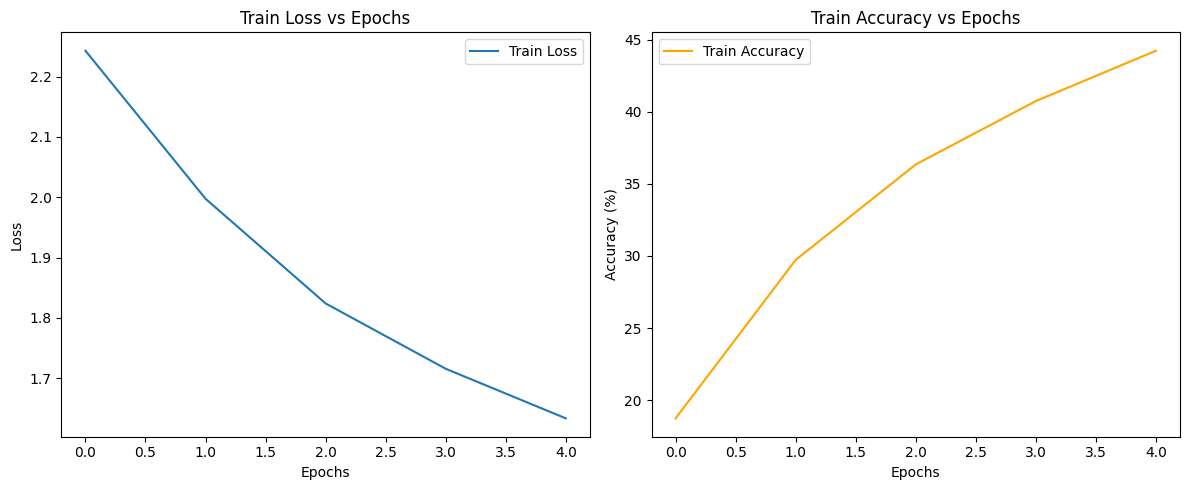

<Figure size 1000x800 with 0 Axes>

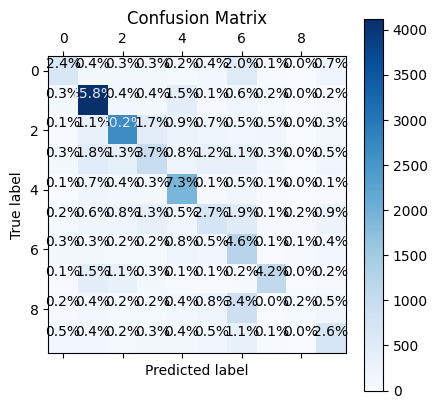

In [24]:
# Plot training history
visualize_results(train_losses, train_accuracies)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)